<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/3b_transfer_loc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localización empleando transferencia

<div style="text-align: right"> Bere et Richardt </div>

En esta libreta entrenaremos un modelo para localización de objetos en el conjunto [Caltech 101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) empleando trasferencia de conocimiento. Este ejemplo está basado en método presentado en [*OverFeat: Integrated Recognition, Localization and Detection using Convolutional Networks*](https://arxiv.org/abs/1312.6229https://arxiv.org/abs/1312.6229) de 2014 por Sermanet et al. 

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/iou.svg" width="950" height="750" />

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# Colab
# https://github.com/TylerYep/torch-summary
!pip install torch-summary

In [2]:
# funciones aleatorias
import random
# sistema de archivos
import os
# flush!
import sys
# procesamiento xml
import xml.etree.ElementTree as ET
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
from scipy.io import loadmat
from torch.utils.data import DataLoader, random_split
# from torchvision.datasets import VisionDataset 
# inspección de arquitectura
from torchsummary import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image


# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 224

# Stats de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
# filas y columnas de la cuadricula 
ROWS, COLS = 4, 8

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

### 1.2 Utilerias

In [3]:
def display_grid(rows, cols, xs, y_true, y_pred=None, 
                 y_true_color='b', y_pred_color='g', figsize=(14, 7)):
    """Despliega ejemplos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            img = xs[i]
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            x, y, w, h = y_true[i]
            rect = patches.Rectangle((x, y), w, h, linewidth=1, 
                                     edgecolor=y_true_color, 
                                     facecolor='none')
            ax[r, c].add_patch(rect)
            if y_pred is not None:
                img_h, img_w = img.shape[:2]
                x, y, w, h = y_pred[i]
                if x + w > img_w:
                    w = img_w - x
                if y + h > img_h:
                    h = img_h - y
                rect = patches.Rectangle((x, y), w, h, linewidth=1, 
                                         edgecolor=y_pred_color, 
                                         facecolor='none')
                ax[r, c].add_patch(rect)
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(rows, cols, x, y_true, y_pred=None, 
                  y_true_color='b', y_pred_color='g', figsize=(14, 7)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)

    y_true = y_true.numpy().astype(np.uint8)
    if y_pred is not None:
        y_pred = y_pred.numpy().astype(np.uint8)
    display_grid(rows, cols, x, y_true, y_pred, 
                 y_true_color=y_true_color,
                 y_pred_color=y_pred_color,
                 figsize=figsize)


def compute_iou(a, b):
    """Computa intersección sobre unión."""
    # obtenemos coordenadas
    xa1, ya1, wa, ha = a.T
    xa2, ya2 = xa1 + wa, ya1 + ha
    xb1, yb1, wb, hb = b.T
    xb2, yb2 = xb1 + wb, yb1 + hb
    # determinar las coordenadas (x, y) del rectangulo de intersección
    xa = torch.max(xa1, xb1)
    ya = torch.max(ya1, yb1)
    xb = torch.min(xa2, xb2)
    yb = torch.min(ya2, yb2)
    # computamos áreas
    area_a = wa * ha
    area_b = wb * hb
    # computamos intersección
    inter = torch.clamp(xb - xa + 1, min=0) * torch.clamp(yb - ya + 1, min=0)
    # computamos unión
    union = area_a + area_b - inter
    # computamos IOU
    iou = torch.mean(inter / union)
    return iou

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

<img src="../figs/comida_datos.svg" width="950" height="750">

### 2.2 Conjunto de datos

In [4]:
# basado en https://github.com/pytorch/vision/blob/master/torchvision/datasets/caltech.py 
class Caltech101:

    def __init__(self, root, transform, download=False):
        self.root = join(root, 'caltech101')
        self.images_dir = join(self.root, '101_ObjectCategories')
        self.annotations_dir = join(self.root, 'Annotations')
        self.transform = transform
        os.makedirs(self.root, exist_ok=True)

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError(
                'Dataset not found or corrupted.' +
                ' You can use download=True to download it')

        # leemos categorias
        self.categories = sorted(os.listdir(self.images_dir))
        # this is not a real class
        self.categories.remove("BACKGROUND_Google")
        
        # For some reason, the category names in "101_ObjectCategories" and
        # "Annotations" do not always match. This is a manual map between the
        # two. Defaults to using same name, since most names are fine.
        name_map = {"Faces": "Faces_2",
                    "Faces_easy": "Faces_3",
                    "Motorbikes": "Motorbikes_16",
                    "airplanes": "Airplanes_Side_2"}
        self.annotation_categories = list(map(
            lambda x: name_map[x] if x in name_map else x, self.categories))


        self.index = []
        self.y = []
        for (i, c) in enumerate(self.categories):
            n = len(os.listdir(join(self.images_dir, c)))
            self.index.extend(range(1, n + 1))
            self.y.extend(n * [i])

    def __getitem__(self, index):
        img = Image.open(join(
            self.images_dir,                  
            self.categories[self.y[index]],
            "image_{:04d}.jpg".format(self.index[index]))
        )
        # si la imagen es escala de grises
        # transformamos a RGB
        if img.mode == 'L':
            rgbimg = Image.new('RGB', img.size)
            rgbimg.paste(img)
            img = rgbimg

        
        data = loadmat(join(
            self.annotations_dir,
            self.annotation_categories[self.y[index]],
            "annotation_{:04d}.mat".format(self.index[index]))
        )
        # [y1, y2, x1, x2]
        box = data["box_coord"][0]

        if self.transform is not None:
            img, box = self.transform(img, box)

        return img, box

    def __len__(self):
        return len(self.index)
    
    def _check_integrity(self):
        return os.path.exists(self.images_dir)

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_and_extract_archive(
            url='https://cloud.xibalba.com.mx/s/fQs7AM4eKY5MbFa/download',
            download_root=self.root,
            filename='caltech101.tar.gz',
            md5='4362a24332bb2029214f0f640224eadc'
        )

### 2.2 Transformación

In [5]:
class Rescale:

    def __init__(self, size, img_tsfm):
        self.size = size
        self.img_tsfm = img_tsfm

    # hace el objeto llamable, 
    # se comporta como una una función
    def __call__(self, img, box):
        # obtenemos las dimensiones originales
        img_w, img_h = img.size
        img = self.img_tsfm(img)
        
        # calculamos escalas
        scale_x = img_w / self.size
        scale_y = img_h / self.size
        # escalamos el cuadro delimitador
        y1, y2, x1, x2 = box
        y1 = int(y1 / scale_y)
        y2 = int(y2 / scale_y)
        x1 = int(x1 / scale_x)
        x2 = int(x2 / scale_x)
        # calculamos ancho y alto
        w = x2 - x1
        h = y2 - y1
        # armamos cuadro delimitador
        box = [x1, y1, w, h]
        box = torch.tensor(box, dtype=torch.float32)
    
        return img, box

### 2.3 Instancia del conjunto y partición

In [6]:
# transofrmación de la imagen
img_tsfm = T.Compose([
    # redimensionamos a 224x224
    T.Resize([IMG_SIZE, IMG_SIZE]),
    # convertimos a torch.Tensor [3,H,W]
    # y escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# transformación conjunta del ejemplo
tsfm = Rescale(IMG_SIZE, img_tsfm)

ds = Caltech101(DATA_DIR, tsfm, download=True)

trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

Files already downloaded and verified


(6941, 1736)

### 2.4 Cargadores de datos

In [7]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # 4 procesos paralelos
    num_workers=4
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # 4 procesos paralelos
    num_workers=4
)

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 4]) dtype=torch.float32


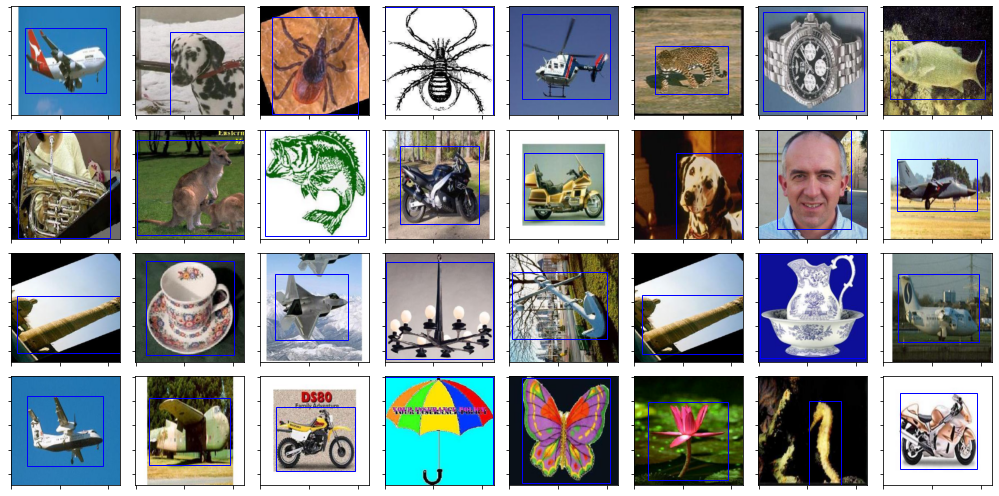

In [8]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(ROWS, COLS, x, y)

## 3 Modelo

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164), una arquitectura eficiente para clasificación de imágenes. 

In [9]:
tvm.shufflenet_v2_x0_5()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

### 3.1 Carga de pesos y transferencia

In [10]:
class SimpleLocNet(nn.Module):
    
    def __init__(self, pretrained):
        super(SimpleLocNet, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.shufflenet_v2_x0_5(pretrained=pretrained)
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.fc = nn.Identity()

        in_features = 1024
        # armamos la capa de regresión
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 4)
        )
    
    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.cnn(x)
        # [N, 1024] => [N, 4]
        x = self.reg(x)
        return x
    
model = SimpleLocNet(True)

# congelado de parámetros de la CNN
for param in model.cnn.parameters():
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
_ = model.eval()

### 3.2 Inspección de la arquitectura

In [11]:
summary(model, (3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─ShuffleNetV2: 1-1                      [-1, 1024]                --
|    └─Sequential: 2-1                   [-1, 24, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 24, 112, 112]        (648)
|    |    └─BatchNorm2d: 3-2             [-1, 24, 112, 112]        (48)
|    |    └─ReLU: 3-3                    [-1, 24, 112, 112]        --
|    └─MaxPool2d: 2-2                    [-1, 24, 56, 56]          --
|    └─Sequential: 2-3                   [-1, 48, 28, 28]          --
|    |    └─InvertedResidual: 3-4        [-1, 48, 28, 28]          (2,400)
|    |    └─InvertedResidual: 3-5        [-1, 48, 28, 28]          (1,512)
|    |    └─InvertedResidual: 3-6        [-1, 48, 28, 28]          (1,512)
|    |    └─InvertedResidual: 3-7        [-1, 48, 28, 28]          (1,512)
|    └─Sequential: 2-4                   [-1, 96, 14, 14]          --
|    |    └─InvertedResidual: 3-8        [-1, 96, 14, 14]   

## 4 Entrenamiento

<img src="../figs/comida_entrenamiento.svg" width="650" height="450">

In [12]:
!nvidia-smi

Mon Nov 16 19:33:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   57C    P0    23W /  N/A |    207MiB /  6078MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
# movemos el modelo 
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Ciclo de entrenamiento

In [ ]:
# optimizador
opt = optim.Adam(model.parameters(), lr=1e-2)

# ciclo de entrenamiento
EPOCHS = 2
for epoch in range(EPOCHS):
    
    # capas de regresión en modo de entrenamiento
    model.reg.train()
    
    # entrenamiento de una época
    for x, y_true in tqdm(trn_dl, desc=f'E{epoch:2d} Train'):
        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)
        # computamos la predicción
        y_pred = model(x)
        # computamos la pérdida
        loss = F.mse_loss(y_pred, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()        

    # capas de regresión en modo de evaluación
    model.reg.eval()    
    
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        mses, ious = [], []
        # validación de la época
        for x, y_true in tqdm(tst_dl, desc=f'E{epoch:2d} Test '):
            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)
            # computamos la predicción
            y_pred = model(x)
            # computamos la pérdida
            mse = F.mse_loss(y_pred, y_true)
            # computamos la IOU
            iou = compute_iou(y_pred, y_true)
            # guardamos históricos
            mses.append(mse.item())
            ious.append(iou.item() * 100)

        # promediamos métricas
        mse = np.mean(mses)
        iou = np.mean(ious)

    # imprimimos métricas
    print(f'E{epoch:2} mse={mse:7.2f} iou={iou:4.2f}')
    sys.stdout.flush()

E 0 Test : 100%|██████████| 55/55 [00:01<00:00, 32.84it/s]

E 0 mse= 499.26 iou=75.08



E 1 Train:  45%|████▌     | 98/217 [00:02<00:03, 36.53it/s]

## 5. Probando

In [ ]:
model = model.to('cpu')

### 5.1 Evaluando en entrenamiento

In [ ]:
with torch.no_grad():
    x, y_true = next(iter(trn_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

### 5.2 Evaluando en prueba

In [ ]:
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

## Quizz 1

Remplaza el modelo preentranado por una arquitectura [MobileNetV2](https://pytorch.org/docs/1.6.0/torchvision/models.html#mobilenet-v2) y después por una [DenseNet121](https://pytorch.org/docs/1.6.0/torchvision/models.html#id16).

## Quizz 2

Realiza trasnferencia de conocimiento reentrenando el modelo completo.